In [3]:
import pandas as pd
import numpy as np

# Load datasets
df1 = pd.read_csv('/content/Crop_recommendation.csv')
df2 = pd.read_csv('/content/crop_production.csv')

# Add investment column with random values
np.random.seed(42)  # For reproducibility
df1['investment'] = np.random.randint(1000, 5000, size=len(df1))

# For merging, assuming a place-based merge is needed, we will just concatenate
# If there's a key to merge on, use pd.merge() with appropriate key
# Example: df_combined = pd.merge(df1, df2[['State_Name', 'District_Name']], left_on='place_column', right_on='District_Name', how='left')
df_combined = pd.concat([df1, df2[['State_Name', 'District_Name']]], axis=1)

# Drop any duplicated columns if needed
df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]


In [6]:
# Check for missing values
print(df_combined.isnull().sum())


N                243891
P                243891
K                243891
temp             243891
humid            243891
ph               243891
rainfal          243891
label            243891
investment       243891
State_Name            0
District_Name         0
dtype: int64


In [8]:
# Fill missing values with a placeholder, if suitable
df_combined['State_Name'] = df_combined['State_Name'].fillna('Unknown')
df_combined['District_Name'] = df_combined['District_Name'].fillna('Unknown')


In [11]:
df_combined = df_combined.dropna()



In [12]:
# Fill missing values with the mode
df_combined['State_Name'].fillna(df_combined['State_Name'].mode()[0], inplace=True)
df_combined['District_Name'].fillna(df_combined['District_Name'].mode()[0], inplace=True)


<ipython-input-12-2623a20c7106>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['State_Name'].fillna(df_combined['State_Name'].mode()[0], inplace=True)
<ipython-input-12-2623a20c7106>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['District_Name'].fillna(df_combined['District_Name'].mode()[0], inplace=True)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define features and target
X = df_combined[['P', 'K', 'temp', 'humid', 'ph', 'rainfal', 'investment']]
y = df_combined['label']

# Encode categorical labels
y = y.astype('category').cat.codes

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and fit the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.99


In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=df_combined['label'].unique()))


              precision    recall  f1-score   support

        rice       1.00      1.00      1.00        34
       maize       1.00      1.00      1.00        26
    chickpea       1.00      1.00      1.00        26
 kidneybeans       1.00      1.00      1.00        34
  pigeonpeas       1.00      1.00      1.00        33
   mothbeans       1.00      1.00      1.00        30
    mungbean       1.00      1.00      1.00        28
   blackgram       1.00      1.00      1.00        23
      lentil       0.85      1.00      0.92        34
 pomegranate       1.00      1.00      1.00        36
      banana       0.96      1.00      0.98        22
       mango       0.96      1.00      0.98        26
      grapes       1.00      1.00      1.00        32
  watermelon       1.00      0.94      0.97        34
   muskmelon       1.00      1.00      1.00        30
       apple       1.00      1.00      1.00        24
      orange       1.00      1.00      1.00        25
      papaya       1.00    

In [15]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')


Cross-Validation Scores: [0.99545455 0.98863636 0.99545455 0.99545455 0.99318182]
Mean CV Score: 0.9936363636363638


In [16]:
# Training accuracy
train_accuracy = model.score(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Test accuracy
test_accuracy = model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


Training Accuracy: 1.00
Test Accuracy: 0.99


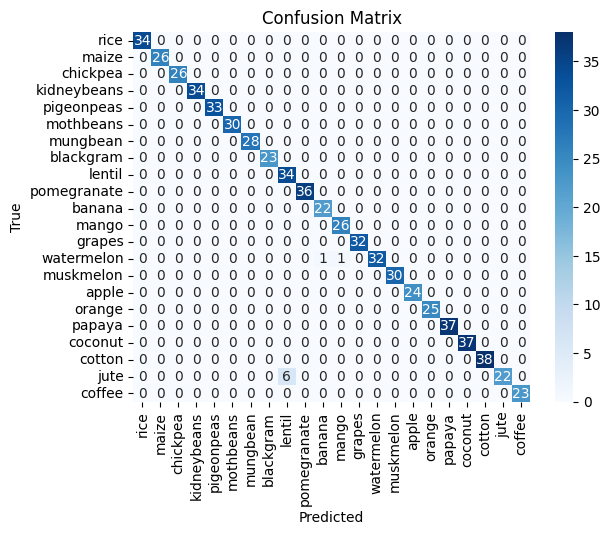

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df_combined['label'].unique(), yticklabels=df_combined['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


      Feature  Importance
5     rainfal    0.244929
3       humid    0.224305
1           K    0.186084
0           P    0.161288
2        temp    0.101074
4          ph    0.072191
6  investment    0.010130


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import numpy as np

# Convert data to 3D array
# Example: Assuming you reshape data into (samples, timesteps, features)
X_reshaped = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))  # Dummy timestep dimension

# Define the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # or 'softmax' for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_reshaped, y, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.0695 - loss: -831.8748 - val_accuracy: 0.0000e+00 - val_loss: -1789.0543
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0615 - loss: -3828.0552 - val_accuracy: 0.0000e+00 - val_loss: -3069.2637
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0665 - loss: -6075.9946 - val_accuracy: 0.0000e+00 - val_loss: -4470.9312
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0602 - loss: -8748.0469 - val_accuracy: 0.0000e+00 - val_loss: -6067.4917
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0580 - loss: -11643.4805 - val_accuracy: 0.0000e+00 - val_loss: -7959.1982
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0650 - loss: -15279.9219 - val_accuracy: 0.0000e+00 - val_loss: -10200.6934
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0547 - loss: -20023.0391 - val_accuracy: 0.0000e+00 - val_loss: -12773.2803
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s

In [22]:
import pandas as pd
import numpy as np



# Load place data
place_data = pd.read_csv('crop_production.csv')

# Check columns
print(place_data.head())

# Randomly assign place data
num_rows = df_combined.shape[0]
random_indices = np.random.choice(place_data.shape[0], num_rows, replace=True)

df_combined['State_Name'] = place_data['State_Name'].iloc[random_indices].values
df_combined['District_Name'] = place_data['District_Name'].iloc[random_indices].values

# Verify the merged data
print(df_combined[['State_Name', 'District_Name']].head())


                    State_Name District_Name  Crop_Year       Season  \
0  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    

                  Crop    Area  Production  
0             Arecanut  1254.0      2000.0  
1  Other Kharif pulses     2.0         1.0  
2                 Rice   102.0       321.0  
3               Banana   176.0       641.0  
4            Cashewnut   720.0       165.0  
      State_Name        District_Name
0          Bihar              KATIHAR
1        Haryana              PANIPAT
2  Uttar Pradesh  GAUTAM BUDDHA NAGAR
3         Odisha           JHARSUGUDA
4    Maharashtra               SANGLI


In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Encode categorical features
label_encoder = LabelEncoder()
df_combined['State_Name'] = label_encoder.fit_transform(df_combined['State_Name'])
df_combined['District_Name'] = label_encoder.fit_transform(df_combined['District_Name'])

# Define features and target
X = df_combined[['P', 'K', 'temp', 'humid', 'ph', 'rainfal', 'investment', 'State_Name', 'District_Name']]
y = df_combined['label']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9893939393939394
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        34
      banana       1.00      1.00      1.00        26
   blackgram       1.00      1.00      1.00        26
    chickpea       1.00      1.00      1.00        34
     coconut       1.00      1.00      1.00        33
      coffee       1.00      1.00      1.00        30
      cotton       1.00      1.00      1.00        28
      grapes       1.00      1.00      1.00        23
        jute       0.87      1.00      0.93        34
 kidneybeans       1.00      1.00      1.00        36
      lentil       0.96      1.00      0.98        22
       maize       0.96      1.00      0.98        26
       mango       1.00      1.00      1.00        32
   mothbeans       1.00      0.94      0.97        34
    mungbean       1.00      1.00      1.00        30
   muskmelon       1.00      1.00      1.00        24
      orange       1.00      1.00      1.00        2

In [27]:
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


         Feature  Importance
5        rainfal    0.246442
3          humid    0.234864
1              K    0.188179
0              P    0.164453
2           temp    0.091552
4             ph    0.057841
6     investment    0.006630
8  District_Name    0.005461
7     State_Name    0.004578


In [30]:
import joblib

# Ensure paths are correct
model_filename = 'crop_predictor_model.pkl'
scaler_filename = 'scaler.pkl'

# Save the trained model
joblib.dump(model, model_filename)
print(f"Model saved as {model_filename}")

# Save the scaler
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved as {scaler_filename}")



Model saved as crop_predictor_model.pkl
Scaler saved as scaler.pkl


In [31]:
print(df_combined.head())

      N     P     K       temp      humid        ph     rainfal label  \
0  90.0  42.0  43.0  20.879744  82.002744  6.502985  202.935536  rice   
1  85.0  58.0  41.0  21.770462  80.319644  7.038096  226.655537  rice   
2  60.0  55.0  44.0  23.004459  82.320763  7.840207  263.964248  rice   
3  74.0  35.0  40.0  26.491096  80.158363  6.980401  242.864034  rice   
4  78.0  42.0  42.0  20.130175  81.604873  7.628473  262.717340  rice   

   investment  State_Name  District_Name  
0      4174.0           4            269  
1      4507.0           9            392  
2      1860.0          29            178  
3      2294.0          21            236  
4      2130.0          16            448  


In [38]:
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd



# Prepare features and target
X = df_combined[['N', 'P', 'K', 'temp', 'humid', 'ph', 'rainfal', 'investment', 'State_Name', 'District_Name']]
y = df_combined['label']

# Handle Label Encoding
label_encoder_state = LabelEncoder()
label_encoder_state.fit(X['State_Name'])

label_encoder_district = LabelEncoder()
label_encoder_district.fit(X['District_Name'])

# Encode categorical variables
X['State_Name'] = label_encoder_state.transform(X['State_Name'])
X['District_Name'] = label_encoder_district.transform(X['District_Name'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_scaled, y)

# Save the model, scaler, and label encoders
joblib.dump(model, 'crop_predictor_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder_state, 'label_encoder_state.pkl')
joblib.dump(label_encoder_district, 'label_encoder_district.pkl')


<ipython-input-38-70d8433dfc88>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['State_Name'] = label_encoder_state.transform(X['State_Name'])
<ipython-input-38-70d8433dfc88>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['District_Name'] = label_encoder_district.transform(X['District_Name'])


['label_encoder_district.pkl']

In [36]:

# Print column names
print("Column names in the dataset:")
print(df_combined.columns)

# Print first few rows to inspect data
print("First few rows of the dataset:")
print(df_combined.head())


Column names in the dataset:
Index(['N', 'P', 'K', 'temp', 'humid', 'ph', 'rainfal', 'label', 'investment',
       'State_Name', 'District_Name'],
      dtype='object')
First few rows of the dataset:
      N     P     K       temp      humid        ph     rainfal label  \
0  90.0  42.0  43.0  20.879744  82.002744  6.502985  202.935536  rice   
1  85.0  58.0  41.0  21.770462  80.319644  7.038096  226.655537  rice   
2  60.0  55.0  44.0  23.004459  82.320763  7.840207  263.964248  rice   
3  74.0  35.0  40.0  26.491096  80.158363  6.980401  242.864034  rice   
4  78.0  42.0  42.0  20.130175  81.604873  7.628473  262.717340  rice   

   investment  State_Name  District_Name  
0      4174.0           4            269  
1      4507.0           9            392  
2      1860.0          29            178  
3      2294.0          21            236  
4      2130.0          16            448  
